# Imports

In [ ]:
# !pip install yfinance

In [1]:
import os
from functools import partial
from datetime import datetime

import numpy as np
import pandas as pd

import utils
import pipelines
import processing

# Download stock daily prices

In [5]:
# Gets all ticker names (no argument given)
ticker_list = utils.get_tickers_by_industry(market_cap_min_mm=1000, market_cap_max_mm=None, industries=[])

In [57]:
# Specific date - 3rd of March 2022 (Y, M, D)
# date_to = datetime(2022, 3, 1)
# Date of today
date_to = datetime.today()
# How many years' of data to download (going backwards from date_end). Year can be a floating point number
period_years = 5

In [58]:
# Download ticker price data for the tickers selected above (saved to .csv automatically)
df, df_clean = utils.download_stonk_prices(ticker_list.index, period_years=period_years, date_to=date_to)

[*********************100%***********************]  2815 of 2815 completed

10 Failed downloads:
- PFE.WI: No data found, symbol may be delisted
- BIP.PRA: No data found, symbol may be delisted
- O.WI: No data found, symbol may be delisted
- POST WI: No data found, symbol may be delisted
- BIP.PRB: No data found, symbol may be delisted
- SNX.WI: No data found, symbol may be delisted
- MRK.WI: No data found, symbol may be delisted
- T WD: No data found, symbol may be delisted
- RXN WI: No data found, symbol may be delisted
- DELL WI: No data found, symbol may be delisted


In [6]:
ticker_list.groupby('subindustry').count()

,market_cap
subindustry,
automobiles_and_components,42
banks,177
capital_goods,231
chemicals,61
commercial_and_professional_services,72
construction_materials,7
consumer_durables_and_apparel,73
consumer_services,99
consumer_staples,121


# Run data pipeline

In [71]:
# Visos industrijos:
# industries = ticker_list['subindustry'].unique()
# Jei nori atskirai po kelias arba po viena (uncomment):
industries = ['technology_hardware_and_equipment']
l_reg = 3
l_roll = 2
dt = 10
date_from = '2017-04-20'
date_to = '2022-04-18'

output_dir = 'data'

In [72]:
i = 1
total_industries = len(industries)
for industry in industries:
    stonks = utils.get_stonk_data_by_industry(date_from, date_to, industries=[industry])
    X, Y = processing.combine_stonk_pairs(stonks)
    
    print('Industry ({0}/{1}): {2}'.format(i, total_industries, industry))
    
    print('Processing residuals...')
    residuals, betas, _ = utils.measure_time(partial(processing.get_rolling_residuals, X=X, Y=Y, l_reg=l_reg, l_roll=l_roll, dt=dt))
    std_residuals, _, _ = processing.get_standardized_residuals(residuals)

    trades_before = len(std_residuals)
    std_residuals = std_residuals[std_residuals.iloc[:, -1].abs() >= 2]
    trades_after = len(std_residuals)
    print('{0} trades selected out of {1} by residual values'.format(trades_after, trades_before))
    if trades_after == 0:
        print('No trades left after filtering residuals, skipping this industry...')
        continue
    residuals = residuals.loc[std_residuals.index]
    betas = betas.loc[std_residuals.index]
    
    print('Processing ADFs...')
    adfs, adfs_raw = utils.measure_time(partial(processing.get_aggregate_adfs, residuals, betas=betas))
    
    selected_by_adf = (adfs >= 0.5).values
    trades_before = len(std_residuals)
    std_residuals = std_residuals[selected_by_adf]
    trades_after = len(std_residuals)
    print('{0} trades selected out of {1} by ADF pass rates'.format(trades_after, trades_before))
    
    if len(std_residuals) == 0:
        print('No trades left after filtering ADF pass rates, skipping this industry...')
        continue

    betas = betas.loc[std_residuals.index]
    residuals = residuals.loc[std_residuals.index]
    adfs_raw = adfs_raw.loc[std_residuals.index]
    
    residuals_max_mean = processing.get_mean_residual_magnitude(std_residuals, dt=21)
    print('Mean max residual value for {0} after filtering is {1}'.format(industry, residuals_max_mean))
    
    print('Writing results to CSV...')
    residuals.to_csv(os.path.join(output_dir, industry + '_residuals.csv'), header=False, index=True)
    betas.to_csv(os.path.join(output_dir, industry + '_betas.csv'), header=False, index=True)
    adfs_raw.to_csv(os.path.join(output_dir, industry + '_adfs_raw.csv'), header=False, index=True)
    adfs.to_csv(os.path.join(output_dir, industry + '_adfs.csv'), header=False, index=True)
    i+= 1
    
print('*** All done ***')

Industry (1/1): technology_hardware_and_equipment
Processing residuals...
Done after: 14s
368 trades selected out of 2701 by residual values
Processing ADFs...
Done after: 37s
78 trades selected out of 368 by ADF pass rates
Mean max residual value for technology_hardware_and_equipment after filtering is 3.509999990463257
Writing results to CSV...
*** All done ***


# Data collection

In [3]:
stonks = utils.get_stonk_data_by_industry('2017-04-20', '2022-04-18', industries=[])

In [4]:
ticker_list = utils.get_tickers_by_industry(market_cap_min_mm=1000, market_cap_max_mm=None, industries=[])

In [ ]:
pipelines.data_collection_rolling_pipeline(stonks, industries=list(ticker_list['subindustry'].unique()), l_reg=3, l_roll=2, dt=20, market_cap_min_mm=1000, market_cap_max_mm=None, adf_pval_cutoff=0.1, adf_pass_rate_filter=0.5, trade_length_months=3, trading_interval_weeks=2)

# Model development

In [226]:
import xgboost as xgb

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from hyperopt import STATUS_OK, STATUS_FAIL, Trials, fmin, hp, tpe

In [122]:
def assign_labels(df):
    def label_one_example(example):
        success_one_month = example['return_one_month'] >= 0.045 and np.abs(example['last_residual'] - example['residual_one_month']) >= 2
        success_two_month = example['return_two_month'] >= 0.065 and np.abs(example['last_residual'] - example['residual_two_month']) >= 2
        success_three_month = example['return_three_month'] >= 0.095 and np.abs(example['last_residual'] - example['residual_three_month']) >= 2
        
        # failure_one_month = example['return_one_month'] <= -0.05 and np.abs(example['last_residual'] - example['residual_one_month']) >= 1.5
        # failure_two_month = example['return_two_month'] <= -0.065 and np.abs(example['last_residual'] - example['residual_two_month']) >= 2
        # failure_three_month = example['return_three_month'] <= -0.095 and np.abs(example['last_residual'] - example['residual_three_month']) >= 2
        
        label_positive = int(any([success_one_month, success_two_month, success_three_month]))
        # label_negative = int(any([failure_one_month, failure_two_month, failure_three_month]))
        
        # if label_positive:
        #     label = 2
        # elif label_negative:
        #     label = 0
        # else:
        #     label = 1
        return label_positive
    
    df_copy = df.copy()
    df_copy['label'] = df_copy.apply(label_one_example, axis=1)
    return df_copy

In [140]:
def transform_features(df, scalers=None, scaling='minmax', add_noise=False):
    def _map_industry(example):
        mappings = {
            'chemicals':'materials',
            'construction_materials':'materials',
            'containers_and_packaging':'materials',
            'metals_and_mining':'materials',
            'paper_and_forest_products':'materials',
            #
            'capital_goods':'industrials',
            'commercial_and_professional_services':'industrials',
            'transportation':'industrials',
            #
            'automobiles_and_components':'consumer_discretionary',
            'consumer_durables_and_apparel':'consumer_discretionary',
            'consumer_services':'consumer_discretionary',
            'retailing':'consumer_discretionary',
            #
            'health_care_equipment_and_services':'health_care',
            'pharmaceuticals_biotechnology_and_life_sciences':'health_care',
            #
            'banks':'financials',
            'diversified_financials':'financials',
            'insurance':'financials',
            #
            'software_and_services':'information_technology',
            'technology_hardware_and_equipment':'information_technology',
            'semiconductors_and_semiconductor_equipment':'information_technology',
            #
            'telecommunication_services':'communication_services',
            'media_and_entertainment':'communication_services',
            #
            'energy':'energy',
            'utilities':'utilities',
            'real_estate':'real_estate',
            'consumer_staples':'consumer_staples'
        }
        return mappings[example['subindustry']]
    
    if not scalers and scaling:
        FIT_SCALERS = True
        scalers = {}
    else:
        FIT_SCALERS = False
    
    def _get_new_scaler():
        if scaling == 'minmax':
            return MinMaxScaler()
        elif scaling == 'standard':
            return StandardScaler()
            
    data_types = {
        'adf_pass_rate':np.float32, 
        'last_residual':np.float32, 
        'residual_mean_max':np.float32,
        'label':np.float32,
    }
    
    df_copy = df.copy()
    n_x = df_copy.shape[0]
    
    # Select features
    df_copy = df_copy[['adf_pass_rate', 'last_residual', 'residual_mean_max', 'subindustry', 'label']].astype(data_types)
    
    # Industry transform
    df_copy.loc[:, 'industry'] = df_copy.apply(_map_industry, axis=1)
    df_copy = df_copy.drop(columns='subindustry')
    df_copy['industry'] = df_copy['industry'].astype('category')
    
    # Residual transform
    df_copy.loc[:, 'last_residual'] = df_copy['last_residual'].abs()
    
    # Feature crossing
    df_copy.loc[:, 'residual_inter'] = df_copy['last_residual'] / df_copy['residual_mean_max']
    
    if add_noise:
        df_copy.loc[:, 'adf_pass_rate']+= np.random.normal(0, 0.025, n_x)
        df_copy.loc[:, 'last_residual']+= np.random.normal(0, 0.025, n_x)
        df_copy.loc[:, 'residual_mean_max']+= np.random.normal(0, 0.025, n_x)
    
    # Scale features
    if scaling:
        # Last residual scaling
        if FIT_SCALERS:
            scalers['last_residual'] = _get_new_scaler().fit(df_copy['last_residual'].to_numpy().reshape(-1, 1))
        scaler = scalers['last_residual']
        df_copy.loc[:, 'last_residual'] = scaler.transform(df_copy['last_residual'].to_numpy().reshape(-1, 1))

        # ADF pass rate scaling
        if FIT_SCALERS:
            scalers['adf_pass_rate'] = _get_new_scaler().fit(df_copy['adf_pass_rate'].to_numpy().reshape(-1, 1))
        scaler = scalers['adf_pass_rate']
        df_copy.loc[:, 'adf_pass_rate'] = scaler.transform(df_copy['adf_pass_rate'].to_numpy().reshape(-1, 1))

        # Residual mean max scaling
        if FIT_SCALERS:
            scalers['residual_mean_max'] = _get_new_scaler().fit(df_copy['residual_mean_max'].to_numpy().reshape(-1, 1))
        scaler = scalers['residual_mean_max']
        df_copy.loc[:, 'residual_mean_max'] = scaler.transform(df_copy['residual_mean_max'].to_numpy().reshape(-1, 1))
    
    return df_copy, scalers

In [125]:
def split_data(df, validation_size=0.1, test_size=0.1, seed=420):
    df_copy = df.copy()
    
    # Shuffle data
    df_copy = df_copy.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    n_validation = int(len(df_copy) * validation_size)
    n_test = int(len(df_copy) * test_size)
    
    df_validation = df_copy.iloc[:n_validation].copy()
    df_test = df_copy.iloc[n_validation:n_validation+n_test].copy()
    df_train = df_copy.iloc[n_validation+n_test:].copy()
    
    return {'train':df_train, 'validation':df_validation, 'test':df_test}

In [126]:
def split_data_by_time(df, hold_out_time_slices, seed=420):
    df_copy = df.copy()
    t_test = hold_out_time_slices // 2
    
    # Shuffle data
    df_copy = df_copy.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    dates_sorted = np.sort(df['trade_date'].unique())
    
    dates_valid = dates_sorted[-hold_out_time_slices:-t_test]
    dates_test = dates_sorted[-t_test:]
    dates_train = dates_sorted[:-hold_out_time_slices]
    
    # Sliced dates should not overlap
    assert len(set(dates_valid) & set(dates_test) & set(dates_train)) == 0
    
    df_validation = df_copy[df_copy.trade_date.isin(dates_valid)].copy().sample(frac=1, random_state=seed)
    df_test = df_copy[df_copy.trade_date.isin(dates_test)].copy().sample(frac=1, random_state=seed)
    df_train = df_copy[df_copy.trade_date.isin(dates_train)].copy().sample(frac=1, random_state=seed)
    
    assert len(
        set(df_validation.trade_date.unique()) & 
        set(df_test.trade_date.unique()) & 
        set(df_train.trade_date.unique())
           ) == 0
    
    return {'train':df_train, 'validation':df_validation, 'test':df_test}

In [127]:
def evaluate_model_predictions_returns(df, y_preds):
    def _classify_prediction(example):
        true_label = example['label']
        prediction = example['prediction']
        
        if true_label == 1 and prediction == 1:
            return 'TP'
        elif true_label == 1 and prediction == 0:
            return 'FN'
        elif true_label == 0 and prediction == 0:
            return 'TN'
        elif true_label == 0 and prediction == 1:
            return 'FP'
        
    df['prediction'] = y_preds
    df['result'] = df.apply(_classify_prediction, axis=1)
    
    print('\nTotals:')
    print(df[['result', 'prediction']].groupby('result').count())
    
    print('\nMeans:')
    print(df[['result', 'return_one_month', 'return_two_month', 'return_three_month']].groupby('result').mean())
    
    print('\nStds:')
    print(df[['result', 'return_one_month', 'return_two_month', 'return_three_month']].groupby('result').std())
    
    
    print('\nPositive predictions:')
    print('\nMeans:')
    print(df[df.prediction == 1][['return_one_month', 'return_two_month', 'return_three_month']].mean())
    
    print('\nStds:')
    print(df[df.prediction == 1][['return_one_month', 'return_two_month', 'return_three_month']].std())
    
    return df

In [128]:
def model_performance_summary(y_score, y_preds, y_true):
        y_baseline = np.ones(len(y_true))
        
        precision = precision_score(y_true, y_preds, zero_division=0)
        f1 = f1_score(y_true, y_preds)
        avg_precision = average_precision_score(y_true, y_score)
        if np.any(y_true):
            roc = roc_auc_score(y_true, y_score)
        else:
            roc = 0
        
        precision_base = precision_score(y_true, y_baseline, zero_division=0)
        
        print("Precision:", precision)
        print("Precision (baseline):", precision_base)
        print("F1 score:", f1)
        print("PR-AUC/AP score:", avg_precision)
        print("ROC-AUC score:", roc)
        print("Total positive predictions: " + str(y_preds.sum()))

In [129]:
def evaluate_model_on_slices(df, y_score, y_preds, on):
    def _eval_performance(_df):
        print('\n' + _df[on].iloc[0] + ':')
        model_performance_summary(_df['score'], _df['prediction'], _df['label'])
        
    df['prediction'] = y_preds
    df['score'] = y_score
    
    df[[on, 'prediction', 'score', 'label']].groupby(on).apply(_eval_performance)

In [130]:
df = pd.read_csv('data/dataset_3.csv')
df = df[df['beta'] > 0]
df = assign_labels(df)

splits = split_data_by_time(df, 6)

In [141]:
scaling = 'minmax'
add_noise = True
df_train, scalers = transform_features(splits['train'], scaling=scaling, add_noise=add_noise)
df_valid, _ = transform_features(splits['validation'], scalers=scalers, scaling=scaling, add_noise=add_noise)
df_test, _ = transform_features(splits['test'], scalers=scalers, scaling=scaling, add_noise=add_noise)

In [142]:
X_train = df_train.drop(columns='label')
y_train = df_train['label']

X_valid = df_valid.drop(columns='label')
y_valid = df_valid['label']

X_test = df_test.drop(columns='label')
y_test = df_test['label']

In [358]:
hyperparameter_space = {
    # Continuous:
    "gamma": hp.uniform("gamma", 0, 5),
    "scale_pos_weight" : hp.uniform("scale_pos_weight", 2.5, 4),
    # Integers:
    "max_depth": hp.quniform("max_depth", 4, 8, 1),
    "min_child_weight" : hp.quniform("min_child_weight", 0, 20, 1),
    "max_delta_step" : hp.quniform("max_delta_step", 0, 5, 1),
    # Choice:
    "colsample_bylevel" : hp.choice("colsample_bytree", np.array([0.5, 0.75, 1])),
    "n_estimators": hp.choice("n_estimators", np.array([25, 50, 100, 150])),
    "subsample": hp.choice("subsample", np.array([0.5, 0.75, 1])),
    }

In [362]:
def optimization_objective(space):
    clf = xgb.XGBClassifier(
        gamma = space['gamma'],
        scale_pos_weight = space['scale_pos_weight'],
        #
        max_depth = int(space['max_depth']),
        min_child_weight = int(space['min_child_weight']),
        max_delta_step = int(space['max_delta_step']),
        #
        colsample_bylevel = space['colsample_bylevel'],
        n_estimators = int(space['n_estimators']), 
        learning_rate = 0.1,
        subsample = space['subsample'],
        #
        seed = 420,
        tree_method = "gpu_hist",
        enable_categorical = True,
        max_cat_to_onehot = 1,
    )
    
    clf.fit(
        X_train, y_train,
        verbose=False,
    )
    
    y_score = clf.predict_proba(X_valid)[:, 1]
    y_preds = y_score > 0.5
    
    precision = precision_score(y_valid.to_numpy(), y_preds, zero_division=0)
    f1 = f1_score(y_valid.to_numpy(), y_preds)
    ap = average_precision_score(y_valid.to_numpy(), y_score)
    roc = roc_auc_score(y_valid.to_numpy(), y_score)
    pos_preds = y_preds.sum()
    pos_labels = y_valid.sum()
    
    if f1 == 0 or precision == 0:
        return {'loss': -ap, 'precision': precision, 'f1_score': f1, 'ap': ap, 'auc': roc, 'pos_preds': pos_preds, 'pos_labels': pos_labels, 'status': STATUS_FAIL}
    else:
        return {'loss': -ap, 'precision': precision, 'f1_score': f1, 'ap': ap, 'auc': roc, 'pos_preds': pos_preds, 'pos_labels': pos_labels, 'status': STATUS_OK}

In [374]:
trials = Trials()

best_hyperparams = fmin(
    fn = optimization_objective,
    space = hyperparameter_space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

trial_vals = trials.vals
trial_vals['f1_score'] = list(map(lambda x: x['f1_score'], trials.results))
trial_vals['precision'] = list(map(lambda x: x['precision'], trials.results))
trial_vals['ap'] = list(map(lambda x: x['ap'], trials.results))
trial_vals['auc'] = list(map(lambda x: x['auc'], trials.results))
trial_vals['pos_preds'] = list(map(lambda x: x['pos_preds'], trials.results))
trial_vals['pos_labels'] = list(map(lambda x: x['pos_labels'], trials.results))

df_trials = pd.DataFrame.from_dict(trial_vals)
df_trials.to_csv('data/trials_29_opt-ap_evals-100_std-scaling_dataset-3_oos_noise.csv', index=False)

100%|█████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/trial, best loss: -0.3459991960454386]


In [216]:
params = { 
    # reg def 0
    "gamma": 2.622576,
    # L2 def 1
    # "reg_lambda" : 1,
    # "reg_alpha" : 0,
    # Class imbalance def 1
    "scale_pos_weight" : 6,
    # Integers:
    "max_depth": 6,
    # Reg def 1
    "min_child_weight" : 3,
    # Class imbalance def 0
    "max_delta_step" : 5,
    # Choice:
    # "colsample_bytree" : 0.75,
    "colsample_bylevel" : 0.5,
    "n_estimators": 100,
    "learning_rate": 0.1,
    "subsample": 0.5,
    # Fixed:
    "seed": 420,
    "tree_method": "gpu_hist",
    # "early_stopping_rounds": 5,
    "enable_categorical": True,
    "max_cat_to_onehot": 1,
    "eval_metric": ["logloss"],
}

clf = xgb.XGBClassifier(
        **params
    )

clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid), (X_train, y_train)])
clf.save_model(os.path.join('data', 'classifier.json'))

[0]	validation_0-logloss:0.67114	validation_1-logloss:0.66642
[1]	validation_0-logloss:0.65271	validation_1-logloss:0.64262
[2]	validation_0-logloss:0.63614	validation_1-logloss:0.62259
[3]	validation_0-logloss:0.62371	validation_1-logloss:0.60607
[4]	validation_0-logloss:0.61196	validation_1-logloss:0.59095
[5]	validation_0-logloss:0.60104	validation_1-logloss:0.57749
[6]	validation_0-logloss:0.59288	validation_1-logloss:0.56632
[7]	validation_0-logloss:0.58393	validation_1-logloss:0.55624
[8]	validation_0-logloss:0.57787	validation_1-logloss:0.54715
[9]	validation_0-logloss:0.57211	validation_1-logloss:0.53878
[10]	validation_0-logloss:0.56682	validation_1-logloss:0.53046
[11]	validation_0-logloss:0.56301	validation_1-logloss:0.52463
[12]	validation_0-logloss:0.55921	validation_1-logloss:0.51858
[13]	validation_0-logloss:0.55542	validation_1-logloss:0.51284
[14]	validation_0-logloss:0.55256	validation_1-logloss:0.50742
[15]	validation_0-logloss:0.54959	validation_1-logloss:0.50296
[1

In [155]:
y_train.value_counts()

0.0    78804
1.0     7982
Name: label, dtype: int64

In [160]:
y_test.value_counts()

0.0    6794
1.0    1138
Name: label, dtype: int64

In [224]:
print("**Validation**")
y_score = clf.predict_proba(X_valid)[:, 1]
threshold = 0.8
y_preds = y_score > threshold

model_performance_summary(y_score, y_preds, y_valid)

df_results_valid = evaluate_model_predictions_returns(splits['validation'], y_preds)

evaluate_model_on_slices(splits['validation'], y_score, y_preds, 'subindustry')

**Validation**
Precision: 0.8571428571428571
Precision (baseline): 0.1623222748815166
F1 score: 0.007926023778071336
PR-AUC/AP score: 0.24677230808488718
ROC-AUC score: 0.6282814697243732
Total positive predictions: 7

Totals:
        prediction
result            
FN            1501
FP               1
TN            7776
TP               6

Means:
        return_one_month  return_two_month  return_three_month
result                                                        
FN              0.054185          0.107370            0.127654
FP              0.000000          0.021000            0.082000
TN              0.002311          0.005852           -0.004762
TP              0.056667          0.082000            0.059333

Stds:
        return_one_month  return_two_month  return_three_month
result                                                        
FN              0.052460          0.065947            0.081670
FP                   NaN               NaN                 NaN
TN            

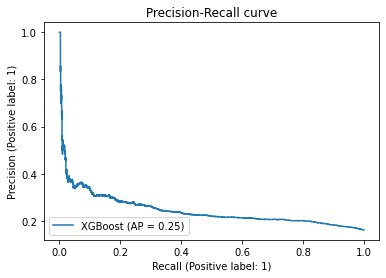

In [218]:
display = PrecisionRecallDisplay.from_predictions(y_valid, y_score, name="XGBoost")
_ = display.ax_.set_title("Precision-Recall curve")

In [228]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_score)

In [230]:
thresholds

(9229,)

In [209]:
df_results_valid[df_results_valid.result == 'FP']

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry,label,prediction,result,score
28542,AGCO,MLI,2021-11-23,0.96,5.87,0.24,11.81,5.07,0.009,5.63,0.07,3.93,0.041,4.74,2016-12-07,capital_goods,0,True,FP,0.801982


In [211]:
print("**Test**")
y_score = clf.predict_proba(X_test)[:, 1]
threshold = 0.7
y_preds = y_score > threshold

model_performance_summary(y_score, y_preds, y_test)

df_results_test = evaluate_model_predictions_returns(splits['test'], y_preds)

evaluate_model_on_slices(splits['test'], y_score, y_preds, 'subindustry')

**Test**
Precision: 0.5714285714285714
Precision (baseline): 0.14346949067070094
F1 score: 0.006986899563318777
PR-AUC/AP score: 0.2234450150429368
ROC-AUC score: 0.5918572574891626
Total positive predictions: 7

Totals:
        prediction
result            
FN            1134
FP               3
TN            6791
TP               4

Means:
        return_one_month  return_two_month  return_three_month
result                                                        
FN              0.069743          0.108325            0.123719
FP              0.064000          0.017333           -0.022333
TN             -0.003019         -0.017211           -0.024684
TP              0.046000          0.143250            0.168500

Stds:
        return_one_month  return_two_month  return_three_month
result                                                        
FN              0.055783          0.071681            0.080811
FP              0.068637          0.014978            0.033247
TN              0.05

C:\Users\dstan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\dstan\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [416]:
df_results_test[df_results_test.result == 'FP']

,ticker_x,ticker_y,trade_date,adf_pass_rate,last_residual,beta,intercept,residual_mean_max,return_one_month,residual_one_month,return_two_month,residual_two_month,return_three_month,residual_three_month,data_window_start,subindustry,label,prediction,result,score
1679,ENPH,KLAC,2022-01-06,0.75,4.66,1.23,108.83,4.71,0.070,3.18,0.205,0.35,0.237,-0.32,2017-01-23,semiconductors_and_semiconductor_equipment,1,True,TP,0.654065
1887,POWI,QCOM,2022-01-06,0.82,2.79,1.47,13.08,4.71,0.016,2.46,0.099,0.78,0.124,0.28,2017-01-23,semiconductors_and_semiconductor_equipment,1,True,TP,0.608563
7552,BMI,UI,2022-02-04,1.00,-3.02,3.52,-50.93,3.43,0.056,-1.48,0.098,-0.34,0.116,0.16,2017-02-21,technology_hardware_and_equipment,1,True,TP,0.648487
9829,AMRC,RRX,2022-02-04,0.96,3.82,1.38,50.41,4.21,0.217,-0.44,0.272,-1.51,0.200,-0.10,2017-02-21,capital_goods,1,True,TP,0.638382
10233,APTV,THRM,2022-01-21,0.59,5.09,0.49,1.40,3.86,0.015,4.55,0.074,2.42,0.050,3.28,2017-02-06,automobiles_and_components,1,True,TP,0.686430
21347,ENTG,KLAC,2022-01-06,0.80,4.17,2.59,22.21,4.71,0.048,1.57,0.086,-0.50,0.033,2.36,2017-01-23,semiconductors_and_semiconductor_equipment,1,True,TP,0.638999
22561,AMRC,ROK,2022-01-21,0.94,3.43,2.50,130.51,4.14,0.136,0.10,0.260,-2.94,0.139,0.04,2017-02-06,capital_goods,1,True,TP,0.638228
24647,EPAM,SSNC,2022-02-04,0.92,2.01,0.05,45.81,4.09,-0.057,3.13,-0.027,2.54,0.118,-0.31,2017-02-21,software_and_services,1,True,TP,0.620695
26641,ABEV,COTY,2022-01-06,1.00,2.04,2.66,-0.20,3.62,0.114,0.90,0.151,0.52,0.183,0.21,2017-01-23,consumer_staples,1,True,TP,0.607940
33831,CYBR,IBM,2022-02-04,0.84,2.01,0.23,87.57,4.09,0.079,0.46,0.076,0.52,-0.026,2.51,2017-02-21,software_and_services,1,True,TP,0.624513


In [32]:
clf.feature_names_in_

array(['adf_pass_rate', 'last_residual', 'residual_mean_max', 'industry',
       'residual_inter'], dtype='<U17')

In [33]:
clf.feature_importances_

array([0.09626307, 0.13465825, 0.13232592, 0.5496204 , 0.0871323 ],
      dtype=float32)

In [156]:
pd.set_option('display.max_rows', 100)

In [368]:
df_trials = pd.read_csv('data/trials_27_opt-ap_evals-1000_no-scaling_dataset-3_oos_noise.csv')
df_trials.sort_values('ap', ascending=False).head(50)

,colsample_bytree,gamma,max_delta_step,max_depth,min_child_weight,n_estimators,scale_pos_weight,subsample,f1_score,precision,ap,auc,pos_preds,pos_labels
383,0,1.794756,1.0,4.0,6.0,0,2.846782,0,0.132191,0.468208,0.343938,0.642545,346,2105.0
869,0,2.986599,1.0,4.0,6.0,0,2.856600,0,0.134310,0.468750,0.343937,0.642538,352,2105.0
963,0,3.357491,1.0,4.0,6.0,0,2.845813,0,0.131429,0.466667,0.343934,0.642542,345,2105.0
922,0,2.935097,1.0,4.0,5.0,0,2.841597,0,0.130666,0.465116,0.343922,0.642541,344,2105.0
798,0,1.597598,1.0,4.0,7.0,0,2.850470,0,0.132191,0.468208,0.343634,0.642575,346,2105.0
422,0,1.859028,1.0,4.0,7.0,0,2.845646,0,0.132191,0.468208,0.343633,0.642577,346,2105.0
382,0,1.485834,1.0,4.0,7.0,0,2.833083,0,0.129455,0.470238,0.343632,0.642583,336,2105.0
581,0,1.632821,1.0,4.0,8.0,0,2.846829,0,0.132191,0.468208,0.343612,0.642551,346,2105.0
424,0,2.078363,1.0,4.0,8.0,0,2.842790,0,0.130666,0.465116,0.343608,0.642550,344,2105.0
603,0,2.588412,1.0,4.0,8.0,0,2.852899,0,0.133605,0.468571,0.343608,0.642550,350,2105.0


In [376]:
df_trials = pd.read_csv('data/trials_28_opt-ap_evals-100_minmax-scaling_dataset-3_oos_noise.csv')
df_trials.sort_values('auc', ascending=False).head(50)

,colsample_bytree,gamma,max_delta_step,max_depth,min_child_weight,n_estimators,scale_pos_weight,subsample,f1_score,precision,ap,auc,pos_preds,pos_labels
97,0,4.192268,1.0,6.0,16.0,0,2.877395,0,0.184499,0.451852,0.342690,0.640459,540,2105.0
36,0,3.970725,4.0,4.0,14.0,0,3.999875,0,0.319211,0.363471,0.342195,0.640143,1648,2105.0
19,1,3.643458,2.0,4.0,0.0,0,3.662248,2,0.298593,0.377358,0.340156,0.639770,1378,2105.0
38,0,3.972122,5.0,4.0,14.0,0,3.368842,0,0.232299,0.437008,0.343476,0.639752,762,2105.0
67,0,4.622576,5.0,6.0,20.0,1,2.906454,0,0.216119,0.451662,0.343517,0.639647,662,2105.0
41,0,4.444676,5.0,6.0,20.0,1,3.145860,0,0.246640,0.421355,0.345081,0.639505,871,2105.0
48,0,1.083825,4.0,6.0,12.0,1,3.001706,0,0.230609,0.425287,0.339874,0.639463,783,2105.0
27,1,3.544209,1.0,4.0,3.0,0,3.929173,2,0.317073,0.358728,0.338469,0.638956,1667,2105.0
21,1,3.173831,0.0,4.0,0.0,0,3.955912,2,0.325163,0.343370,0.338203,0.638885,1893,2105.0
3,0,0.678577,2.0,4.0,9.0,1,3.336393,1,0.269811,0.399070,0.334982,0.638689,1075,2105.0


In [375]:
df_trials = pd.read_csv('data/trials_29_opt-ap_evals-100_std-scaling_dataset-3_oos_noise.csv')
df_trials.sort_values('ap', ascending=False).head(50)

,colsample_bytree,gamma,max_delta_step,max_depth,min_child_weight,n_estimators,scale_pos_weight,subsample,f1_score,precision,ap,auc,pos_preds,pos_labels
77,1,0.053374,3.0,4.0,1.0,3,3.614422,1,0.288636,0.374810,0.345999,0.637412,1318,2105.0
25,1,4.605858,4.0,4.0,18.0,2,3.551774,2,0.282707,0.385246,0.344225,0.640232,1220,2105.0
65,1,0.902030,4.0,4.0,9.0,2,3.836586,1,0.310242,0.362310,0.344195,0.637650,1576,2105.0
71,1,1.248245,4.0,4.0,5.0,2,3.906156,1,0.320383,0.364186,0.344016,0.638177,1653,2105.0
68,1,0.977062,4.0,4.0,5.0,2,3.904721,1,0.320639,0.364848,0.343878,0.638092,1650,2105.0
97,1,0.907730,4.0,4.0,12.0,3,3.281421,2,0.250571,0.400000,0.343177,0.640707,960,2105.0
54,1,3.873847,4.0,4.0,13.0,2,3.856821,1,0.316527,0.365960,0.342529,0.637065,1604,2105.0
60,1,0.818217,4.0,4.0,12.0,2,3.853354,1,0.307525,0.360845,0.342098,0.638616,1563,2105.0
73,1,1.446864,3.0,4.0,8.0,2,3.532902,1,0.290639,0.388095,0.342090,0.638094,1260,2105.0
12,1,3.484578,5.0,4.0,18.0,2,3.406562,2,0.270372,0.394353,0.341474,0.639925,1098,2105.0


# Other

In [27]:
def predict_baseline_model(X_train, y_train, X_valid, y_valid, baseline='rule-based', residual_cutoff_adj=0, adf_cutoff=0.5):
    def class_positive(example):
        if all([
            np.abs(example['last_residual']) > (example['residual_mean_max'] + residual_cutoff_adj),
            example['adf_pass_rate'] > adf_cutoff,
        ]):
            return 1
        else:
            return 0
        
    if baseline == "rule-based":
        y_train_preds = X_train.apply(class_positive, axis=1).to_numpy()
        y_valid_preds = X_valid.apply(class_positive, axis=1).to_numpy()
    elif baseline == "random":
        y_train_preds = np.random.randint(0, 2, len(X_train))
        y_valid_preds = np.random.randint(0, 2, len(X_valid))
    
    precision = precision_score(y_train.to_numpy(), y_train_preds)
    f1 = f1_score(y_train.to_numpy(), y_train_preds)
    print("Final baseline precision on train:", precision)
    print("Final baseline F1 score on train:", f1)

    precision = precision_score(y_valid.to_numpy(), y_valid_preds)
    f1 = f1_score(y_valid.to_numpy(), y_valid_preds)
    print("Final baseline precision on validation:", precision)
    print("Final baseline F1 score on validation:", f1)

In [28]:
def predict_random_forest(X_train, y_train, X_valid, y_valid):
    clf = RandomForestClassifier(
        n_estimators = 100,
        max_depth = None,
        max_features = "auto",
        oob_score = False,
        class_weight = "balanced_subsample",
    )
    
    clf.fit(X_train, y_train)
    
    y_train_preds = clf.predict(X_train)
    y_valid_preds = clf.predict(X_valid)
    
    precision = precision_score(y_train.to_numpy(), y_train_preds)
    f1 = f1_score(y_train.to_numpy(), y_train_preds)
    auc = roc_auc_score(y_train.to_numpy(), y_train_preds)
    
    print("Final RF precision on train:", precision)
    print("Final RF F1 score on train:", f1)
    print("Final RF AUC score on train:", auc)
    
    precision = precision_score(y_valid.to_numpy(), y_valid_preds)
    f1 = f1_score(y_valid.to_numpy(), y_valid_preds)
    auc = roc_auc_score(y_valid.to_numpy(), y_valid_preds)
    
    print("Final RF precision on valid:", precision)
    print("Final RF F1 score on valid:", f1)
    print("Final RF AUC score on valid:", auc)